In [1]:
from resources.notebook_library import *
from resources.gate_simulation.ghz import ghz_simulation
from resources.gate_simulation.ghz import gate_simulation_functions
from resources.dataframe_lib import conditionally_append_result
GateSimulation  = ghz_simulation
sim = GateSimulation.Simulation('O-x-O',load_setup=True,load_analytical=True)

Loading O-x-O setup
Preparing Analytical sub-class
Preparing SuperoperatorBellPair sub-class

Done!


# Obtain grid(s) of performance

In [2]:
# Global Parameters 
kSweep = [0.9,0.95,0.99]   #[0.995]


SplitSweep =[3,5,10,20] #,5,10,20
 

# Bounds of optimization
## DE will be multiplied by  np.sqrt(C_val)
DE_C_min = 1
DE_C_max = 20
C_c_min = 0.1
C_c_max = 10
tg_min = 0.7
tg_max = 1.1
rot_p_min = - np.pi/2 
rot_p_max = - rot_p_min
rot_i_min = - np.pi/2  
rot_i_max = -rot_i_min
rot_b_min = - np.pi/2 * 10**(-20)
rot_b_max = -rot_b_min

# Optimization settings
opt_settings_dict = {
"ghz_dim":2,                # 3-ghz state or 4-ghz state
'swap_into_memory':False,    # Use of nuclear memory  None corresponds to seeking for a maximum
'fidelity_cap': 0.99 ,
'confidence_interval':0.99, #Cost function parameters
"n_cores": 13,  # Number of cores to use in optimization
"disp_bool" : False, "maxiter":None} # Show optimization progress

## Using analytical simulations

In [9]:
n_repeats = 4

for rep_no in range(n_repeats):  
    AllParams = [((ai,a),(bi,b)) for ai,a in enumerate(kSweep) for bi,b in enumerate(SplitSweep)] # Create a 2-d grid for hardware parameters

    TotalParamElems = NumElemsInList(AllParams)


    CurrentNumberOfSimulations = 1
    Results = [ [{} for j in range(len(SplitSweep))] for i in range(len(kSweep))]
    for  ((k_ind,k_val),(mx_spl_ind,mx_spl)) in AllParams:
        print(f'Optimizing {CurrentNumberOfSimulations} out of {TotalParamElems} , Repetition Number:{rep_no+1}')
        CurrentNumberOfSimulations +=1
        c_val = k_val/ (4-4*k_val)
        
        hardware_dict = {sg.var('c'): c_val,sg.var('k'):k_val  ,sg.var('D_max'): mx_spl}

        sim.Analytical.obtain_gate_performance_hardware(hardware_dict)
        bounds = [[C_c_min*c_val,C_c_max*c_val],[0 , mx_spl] , 
                    [DE_C_min,DE_C_max ] , [tg_min,tg_max]  ]
        # Add rotation bounds depending on the ghz_dim
        #for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_min,rot_max]) 
        for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_p_min,rot_p_max]) 
        for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_i_min,rot_i_max]) 
        if opt_settings_dict["ghz_dim"] >2:
            bounds.append([rot_p_min,rot_p_max]) 
            bounds.append([rot_i_min,rot_i_max]) 
        
        sim.Analytical.optimize_gate_performance_hardware(bounds,opt_settings_dict)
        
        optimized_performance_dict = sim.Analytical.optimized_performance_dict
        opt_cost_function = gate_simulation_functions.gate_performance_cost_function(optimized_performance_dict,opt_settings_dict)

        tunable_params_dict = sim.Analytical.opt_tunable_dict
        
        result = {'hardware': hardware_dict , 
                'performance': optimized_performance_dict,
                'tuning': tunable_params_dict,
                'opt_settings' : opt_settings_dict, 
                'cost': opt_cost_function}

        Results[k_ind][mx_spl_ind] = result
        conditionally_append_result(result)
        gc.collect()  # clear unreferenced memory
        clear_output(wait=True)

Optimizing 12 out of 12 , Repetition Number:3


# Plot result

In [3]:
plot_results(Results,plot_big=True)
costs = np.array([[Results[i][j]['cost'] for j in range(len(SplitSweep))]for i in range(len(kSweep))])
res_min = Results[ArgMin(costs)[0]][ArgMin(costs)[1]]
pprint(res_min)


NameError: name 'Results' is not defined

# Print results

In [ ]:

for i,C in enumerate(kSweep):
    for j,spl in enumerate(SplitSweep):
        #conditionally_append_result(Results[i][j])
        pass
        #print(Results[i][j]['tuning'][sg.var('DE')]/np.sqrt(C))
        #print(Results[i][j]['tuning'][sg.var('De')],spl)
        #print([Results[i][j]['tuning'][sg.var(f'r{k}_r')]  for k in range(opt_settings_dict["ghz_dim"] ) ])
        print(best_results[i][j]['tuning'][sg.var('tgr')],best_results[i][j]['hardware'][sg.var('D_max')])
pprint(Results[1][0])

# Superoperator

In [23]:


res_min["tuning"][sg.var('De0')] =  res_min["tuning"][sg.var('De')] - res_min["hardware"][sg.var('D_max')] 
res_min["tuning"][sg.var('r1_p')] =res_min["tuning"][sg.var('r0_p')]
res_min["tuning"][sg.var('r1_i')] =res_min["tuning"][sg.var('r0_i')]
tuning_dict = res_min["tuning"]
tuning_dict[sg.var('c')] = res_min['hardware'][sg.var('c')]
super_perf = sim.SuperoperatorBellPair.simulate(tuning_dict,gamma_g_is_zero=False)

In [24]:
super_perf

{'fidelity': 0.9899522910514534,
 'p_success': 0.037244011891532126,
 'gate_time': 436.8601195515147,
 'concurrence': 0.9615418795358935}

In [5]:
super_perf = sim.SuperoperatorBellPair.simulate(best_results[3][3],analytical_output=True,gamma_g_is_zero=False)

# Load Best Results

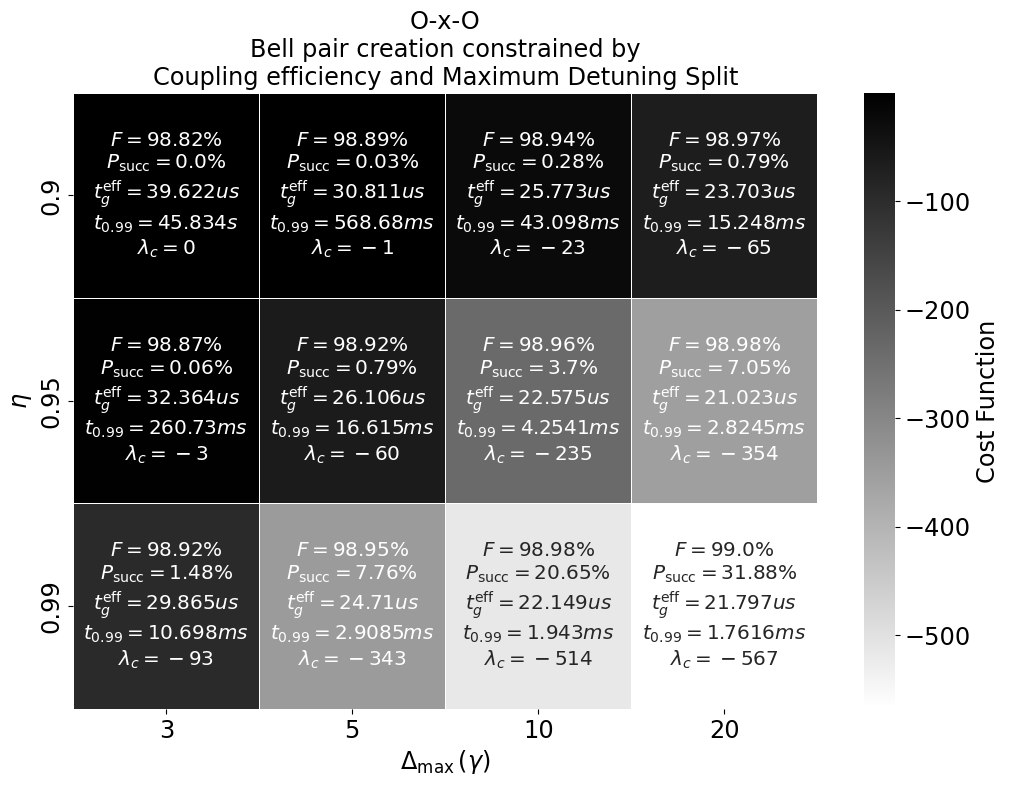

In [3]:
from resources.dataframe_lib import retrieve_result
best_results = [ [{} for j in range(len(SplitSweep))] for i in range(len(kSweep))]

use_super = True
fidelity_cap = 0.99

ghz_dim = 2
for i,k in enumerate(kSweep):
    for j,spl in enumerate(SplitSweep):
        best_results[i][j] = retrieve_result(k,spl,fidelity_cap,ghz_dim)
        if use_super:
            super_perf = sim.SuperoperatorBellPair.simulate(best_results[i][j],analytical_output=True,gamma_g_is_zero=False)
            best_results[i][j]['super_simulation'] = {'density_matrix':super_perf['density_matrix'] ,
                                        'p_success':super_perf['p_success'] ,
                                        'eff_time': gate_simulation_functions.effective_gate_time(super_perf['gate_time']),
                                        'fidelity':super_perf['fidelity']   }


plot_results(best_results,setup=sim.setup_char,plot_big=True,super=use_super)
costs = np.array([[best_results[i][j]['cost'] for j in range(len(SplitSweep))]for i in range(len(kSweep))])
res_min = best_results[ArgMin(costs)[0]][ArgMin(costs)[1]]
#pprint(res_min)
        

# Save results without sage

In [4]:
from resources.dataframe_lib import cast_sage_variables_to_str
q_99 = []
for i in range(3):
    for j in range(4):
        q_99.append(best_results[i][j])

for i in range(len(q_99)):
    super_perf = sim.SuperoperatorBellPair.simulate(q_99[i],analytical_output=True,gamma_g_is_zero=False)
    q_99[i]['super_simulation'] = {'density_matrix':super_perf['density_matrix'] ,
                                    'p_success':super_perf['p_success'] ,
                                    'eff_time': gate_simulation_functions.effective_gate_time(super_perf['gate_time']),
                                    'fidelity':super_perf['fidelity']   }
    #cast sg.vars to str
    dicts_to_subs = ['hardware', 'tuning']
    q_99[i] = cast_sage_variables_to_str(q_99[i],dicts_to_subs)
            

In [5]:
data = np.load('99fidelitystates.npy',allow_pickle=True)
for i in range(len(data)):
    den_matr = data[i]['super_simulation']['density_matrix'] 
    p_success =  data[i]['super_simulation']['p_success'] 
    eff_time =  data[i]['super_simulation']['eff_time'] 

    pass

In [6]:
eff_time

2.1796811227520752e-05